# Airfoil optimization

In [1]:
from IPython.display import SVG, display


#stuff for neurofoil - pip install neuralfoil
from aerosandbox.geometry.airfoil.airfoil_families import get_kulfan_parameters, get_kulfan_coordinates
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p


import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

import sys
import os

## Procedure 

Sources:
* http://servidor.demec.ufpr.br/CFD/bibliografia/aerodinamica/kulfan_2007.pdf
* https://www.tandfonline.com/doi/epdf/10.1080/19942060.2024.2445144
* https://github.com/peterdsharpe/NeuralFoil


Here the PINN is allready trained an provides the prediction. Therefore, the idea is, we shift the quantum opt. part to approximate a policy. 

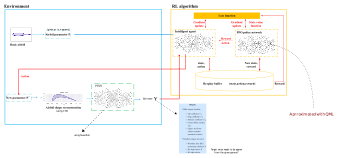

In [2]:
display(SVG(filename="optimprocedure.svg"))

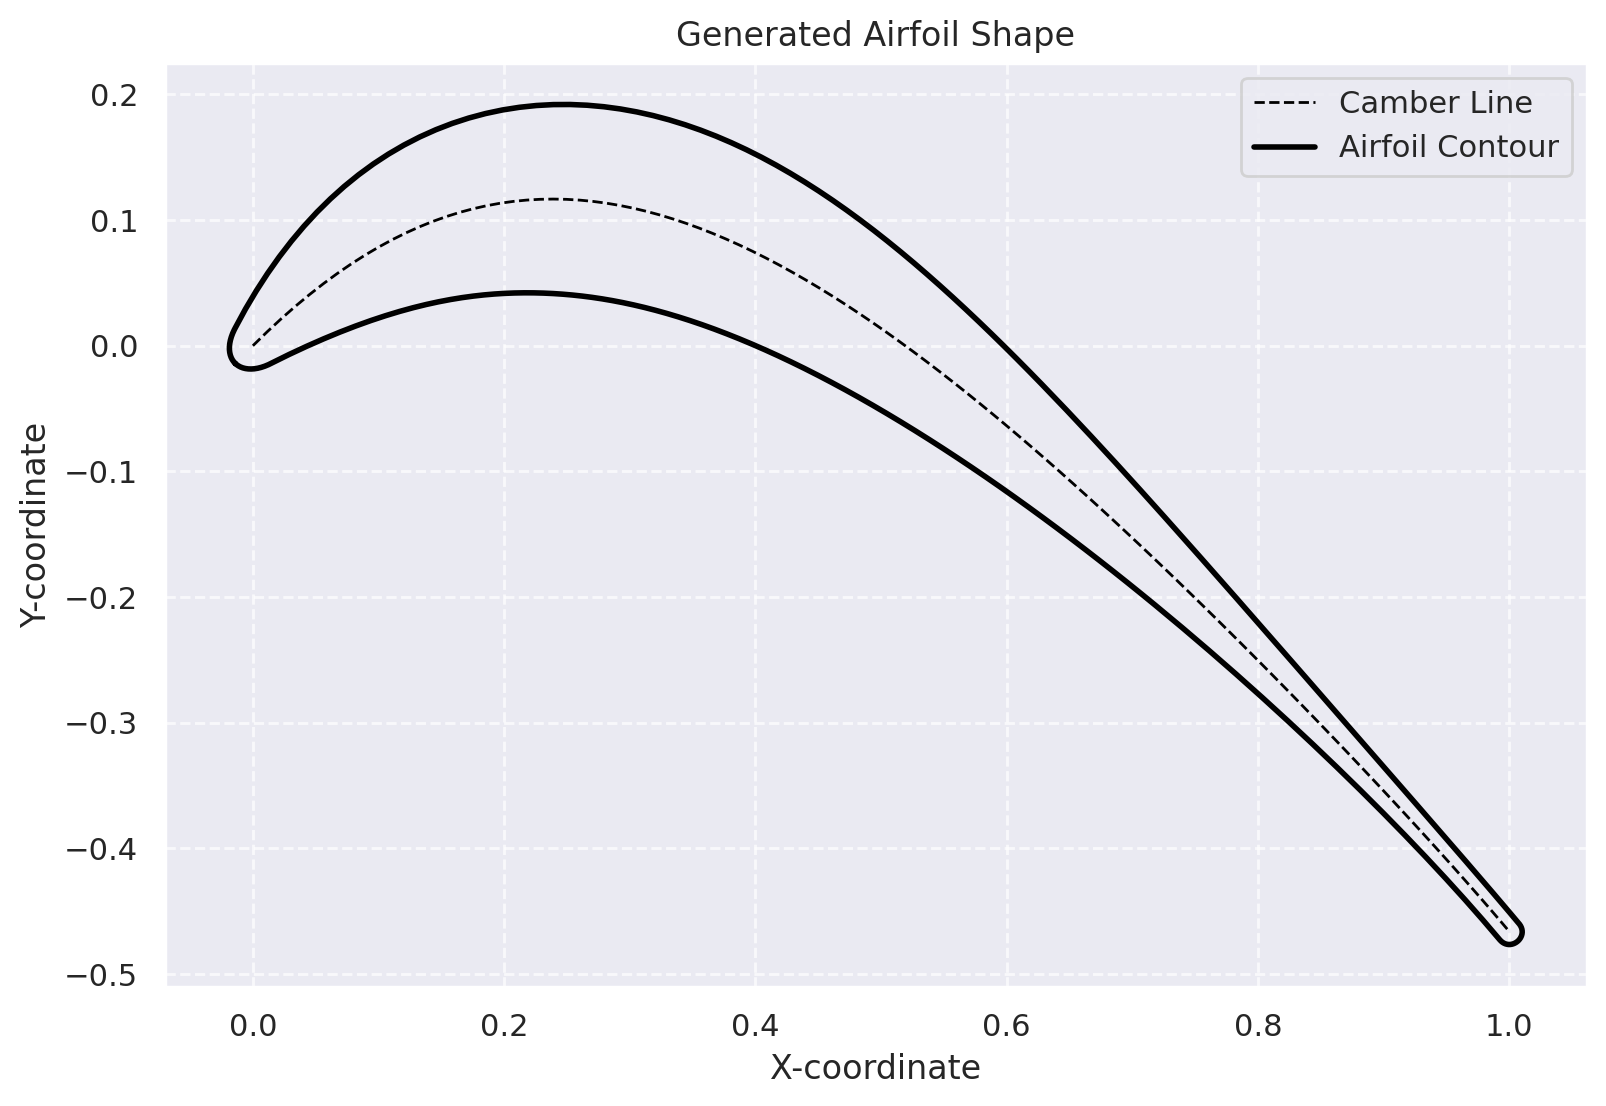

Wrote: airfoil_points.dat


In [3]:
sys.path.append(os.path.abspath("../blade_design_tools"))
import create_airfoil
airfoil_top_points, airfoil_bottom_points, camber_curve_points = create_airfoil.generate_shape(config_filepath="../blade_design_tools/airfoil_config.yaml")

In [4]:
def get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points):
    """
        stacking is up for neurofoil
    """
    # Upper surface: reverse to go from TE to LE
    upper_te_to_le = np.flip(airfoil_top_points, axis=0)

    # Lower surface: LE to TE as is
    lower_le_to_te = airfoil_bottom_points

    # Check if LE points match (for sharp LE); avoid duplicating if so
    if np.allclose(upper_te_to_le[-1], lower_le_to_te[0]):
        coordinates = np.vstack((upper_te_to_le, lower_le_to_te[1:]))
    else:
        coordinates = np.vstack((upper_te_to_le, lower_le_to_te))
    return coordinates


# 7. Export for NeuralFoil
coordinates = get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points)
kulfan_params = get_kulfan_parameters(coordinates)
print("Kulfan parameters:", kulfan_params)

Kulfan parameters: {'lower_weights': array([-0.28488276,  1.00177878, -0.23685353,  0.9467438 ,  0.10084023,
        0.4225717 ,  0.51829065,  0.28131739]), 'upper_weights': array([ 0.77716142,  0.88378783,  0.41653862,  1.15102573, -0.04072576,
        1.10118979,  0.08836566,  0.73546755]), 'TE_thickness': 0.010981105304540521, 'leading_edge_weight': -0.05905102280988277}


In [5]:
kulfan_airfoil = asb.KulfanAirfoil(name="State p'", **kulfan_params)

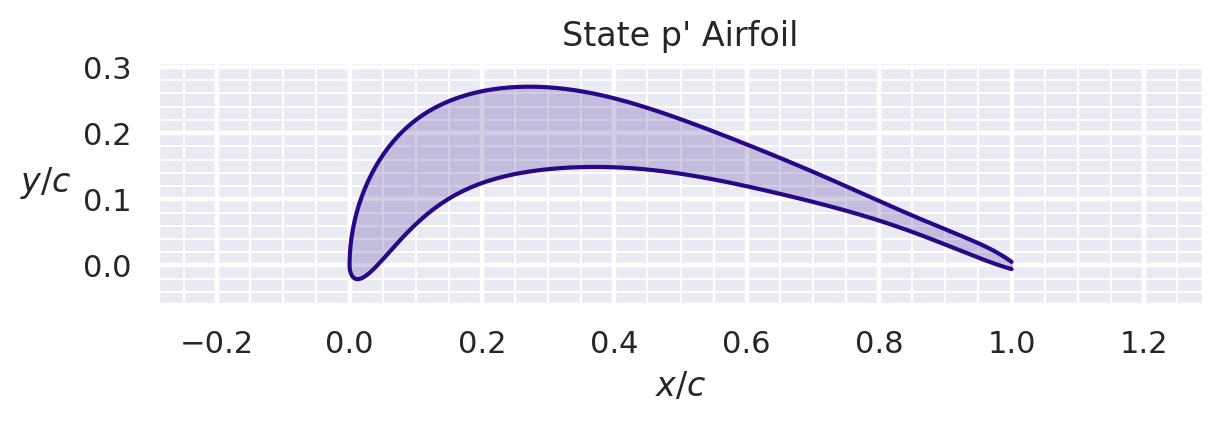

In [6]:
fig, ax = plt.subplots(figsize=(6, 2))
kulfan_airfoil.draw()

In [7]:
initial_guess_airfoil = kulfan_airfoil
opti = asb.Opti()

In [8]:
CL_multipoint_targets = np.array([0.8, 1.0, 1.2, 1.4, 1.5, 1.6])
CL_multipoint_weights = np.array([5, 6, 7, 8, 9, 10])

Re = 500e3 * (CL_multipoint_targets / 1.25) ** -0.5
mach = 0.7

In [9]:
optimized_airfoil = asb.KulfanAirfoil(
    name="Optimized",
    lower_weights=opti.variable(
        init_guess=initial_guess_airfoil.lower_weights,
        lower_bound=-0.5,
        upper_bound=0.25,
    ),
    upper_weights=opti.variable(
        init_guess=initial_guess_airfoil.upper_weights,
        lower_bound=-0.25,
        upper_bound=0.5,
    ),
    leading_edge_weight=opti.variable(
        init_guess=initial_guess_airfoil.leading_edge_weight,
        lower_bound=-1,
        upper_bound=1,
    ),
    TE_thickness=kulfan_params["TE_thickness"],
)

alpha = opti.variable(
    init_guess=45
)

In [10]:
aero = optimized_airfoil.get_aero_from_neuralfoil(
    alpha=alpha,
    Re=Re,
    mach=mach,
)

# Test optimization frame work
### TODO's: 
- Implement real costfunction
- Shape constraints
- Implement the PPO, here we compare standard PPO vs. Quantum PPO

In [57]:
opti.subject_to([
    aero["analysis_confidence"] > 0.90,
    aero["CL"] == CL_multipoint_targets,
    np.diff(alpha) > 0,
    aero["CM"] >= -0.133,
    optimized_airfoil.local_thickness(x_over_c=0.33) >= 0.128,
    optimized_airfoil.local_thickness(x_over_c=0.90) >= 0.014,
    optimized_airfoil.TE_angle() >= 6.03, 
    optimized_airfoil.lower_weights[0] < -0.05,
    optimized_airfoil.upper_weights[0] > 0.05,
    optimized_airfoil.local_thickness() > 0
])

get_wiggliness = lambda af: sum([
    np.sum(np.diff(np.diff(array)) ** 2)
    for array in [af.lower_weights, af.upper_weights]
])

opti.subject_to(
    get_wiggliness(optimized_airfoil) < 2 * get_wiggliness(initial_guess_airfoil)
)


# Formulate an optimization goal based
opti.minimize(np.mean(aero["CD"] * CL_multipoint_weights))

sol = opti.solve(
    behavior_on_failure="return_last",
    options={
        "ipopt.mu_strategy": 'monotone',
        "ipopt.start_with_resto": 'yes'
    }
)

optimized_airfoil = sol(optimized_airfoil)
aero = sol(aero)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      432
Number of nonzeros in inequality constraint Jacobian.:     8106
Number of nonzeros in Lagrangian Hessian.............:      774

Total number of variables............................:       77
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       24
Total number of inequality constraints...............:      629
        inequality constraints with only lower bounds:      547
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       82

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8169224e+00 1.59e+00 1.13e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  83r 1.3331260e+00 9.00e-01 1.99e+02  -0.0 2.14e-01   2.9 1.00e+00 1.00e+00f  1
  84r 1.3180673e+00 9.00e-01 2.07e+02  -0.0 4.98e-01   2.4 9.41e-01 1.85e-01f  1
  85r 1.2496466e+00 9.00e-01 1.39e+02  -0.0 1.48e+00   1.9 6.46e-01 3.06e-01f  1
  86r 1.2430602e+00 9.00e-01 1.39e+02  -0.0 8.76e+00   1.5 2.33e-02 1.49e-02f  1
  87r 1.2266910e+00 9.00e-01 1.74e+02  -0.0 2.22e+00   1.9 3.21e-01 8.07e-02f  1
  88r 1.2257997e+00 9.00e-01 1.56e+02  -0.0 3.62e+00   1.4 1.13e-01 9.23e-02f  1
  89r 1.2347527e+00 9.00e-01 5.28e+02  -0.0 2.16e-01   2.7 1.49e-01 9.25e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 1.2454368e+00 9.00e-01 1.49e+02  -0.0 1.01e-01   3.2 1.00e+00 1.00e+00f  1
  91r 1.2483509e+00 9.00e-01 1.40e+02  -0.0 3.48e-02   3.6 1.00e+00 9.03e-01f  1
  92r 1.2562344e+00 9.00e-01 1.32e+02  -0.0 1.00e-01   3.1 1.00e+00 1.00e+00f  1
  93r 1.3196428e+00 9.00e-01 2.61e+02  -0.0 3.08e-01   2.6 1.00e+00 1.00e+00f  1
  94r 1.3530643e+00 9.00e-01

 176r 2.0074632e+00 9.00e-01 1.61e+01  -2.2 2.04e+00  -0.7 6.55e-01 4.78e-02h  1
 177r 2.0078991e+00 9.00e-01 2.80e+00  -2.2 8.50e-02  -0.3 2.29e-01 1.00e+00h  1
 178r 2.0080472e+00 9.00e-01 4.31e+00  -2.2 1.74e+01    -  6.82e-01 1.35e-01f  3
 179r 2.0081115e+00 9.00e-01 4.57e+00  -2.2 2.37e+01    -  3.13e-01 6.78e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 2.0081203e+00 9.00e-01 4.68e+00  -2.2 1.38e+01    -  1.04e-01 9.95e-03f  3

 182r 2.0081796e+00 9.00e-01 5.32e+00  -2.2 1.39e+01    -  1.53e-01 2.84e-02h  6
 183r 2.0085050e+00 9.00e-01 3.13e+00  -2.2 1.46e+01    -  2.51e-01 4.00e-01f  1
 184r 2.0085439e+00 9.00e-01 1.73e+01  -2.2 2.15e+00  -0.8 6.46e-02 1.45e-01f  1
 185r 2.0085439e+00 9.00e-01 1.86e+01  -2.2 5.39e+03  -1.3 8.63e-05 3.81e-05f  1
 186r 2.0085575e+00 9.00e-01 2.11e+01  -2.2 1.67e+00   0.1 7.16e-02 2.19e-01f  1
 187r 2.0085681e+00 9.00e-01 3.84e+01  -2.2 7.49e+00  -0.4 1.57e-02 7.29e-02f  1
 188r 2.0085724e+00 9.00e-0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270r 2.0131314e+00 9.00e-01 7.41e+00  -3.2 4.78e+00  -0.7 5.25e-02 1.04e-02h  1
 271r 2.0131314e+00 9.00e-01 6.01e+00  -3.2 8.27e-01  -0.3 1.27e-01 1.75e-01h  1
 272r 2.0131314e+00 9.00e-01 2.81e+01  -3.2 8.74e-01   0.1 8.82e-02 1.00e+00h  1
 273r 2.0131314e+00 9.00e-01 2.81e+01  -3.2 1.96e+03    -  6.89e-04 1.77e-04f  1
 274r 2.0131314e+00 9.00e-01 2.87e+01  -3.2 5.42e+02    -  2.20e-02 1.39e-02f  1
 275r 2.0131314e+00 9.00e-01 2.69e+01  -3.2 8.34e+01    -  1.74e-03 8.61e-02f  1
 276r 2.0131314e+00 9.00e-01 2.68e+01  -3.2 1.03e+00  -0.3 3.13e-03 5.17e-03h  1
 277r 2.0131314e+00 9.00e-01 1.47e+01  -3.2 1.64e+00  -0.8 9.48e-03 2.93e-01f  1
 278r 2.0131314e+00 9.00e-01 2.02e+01  -3.2 1.61e+00  -0.4 6.71e-02 1.66e-01h  1
 279r 2.0131314e+00 9.00e-01 1.78e+01  -3.2 1.29e-01   0.9 1.79e-01 1.23e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 2.0131314e+00 9.00e-01

 363r 2.0131314e+00 9.00e-01 3.73e+00  -3.2 3.24e+00  -1.6 1.86e-01 4.46e-02f  2
 364r 2.0131314e+00 9.00e-01 3.30e+00  -3.2 8.59e-01  -2.0 2.05e-01 6.70e-02h  4
 365r 2.0131314e+00 9.00e-01 3.30e+00  -3.2 8.09e+00  -2.5 2.79e-02 6.40e-04h  7
 366r 2.0131314e+00 9.00e-01 1.23e+00  -3.2 5.00e-01  -2.1 1.00e+00 6.25e-01H  1
 367r 2.0131314e+00 9.00e-01 1.20e+00  -3.2 1.23e+01    -  1.34e-01 5.44e-02h  3
 368r 2.0131314e+00 9.00e-01 9.51e-01  -3.2 2.51e+00    -  1.00e+00 5.52e-01H  1
 369r 2.0131314e+00 9.00e-01 5.81e-01  -3.2 1.25e+01    -  4.07e-02 2.15e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370r 2.0131314e+00 9.00e-01 5.69e-01  -3.2 1.40e+01    -  2.02e-01 1.74e-02h  5
 371r 2.0131314e+00 9.00e-01 1.20e+00  -3.2 6.64e+00    -  5.46e-01 4.01e-02h  4
 372r 2.0131314e+00 9.00e-01 8.95e-01  -3.2 6.35e-01    -  8.33e-01 5.48e-01h  1
 373r 2.0131314e+00 9.00e-01 4.70e-01  -3.2 1.40e+01    -  1.29e-01 7.35e-02f  2
 374r 2.0131314e+00 9.00e-01

 457r 2.0131314e+00 9.00e-01 1.08e+01  -3.2 3.68e+00  -0.1 8.65e-02 2.65e-02f  1
 458r 2.0131314e+00 9.00e-01 3.43e+01  -3.2 1.19e+00   0.3 2.61e-01 4.44e-01f  1
 459r 2.0131314e+00 9.00e-01 3.42e+01  -3.2 1.16e+00  -0.2 1.20e-03 1.99e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460r 2.0131314e+00 9.00e-01 3.18e+01  -3.2 2.02e+01    -  3.28e-02 7.33e-02f  1
 461r 2.0131314e+00 9.00e-01 3.03e+01  -3.2 1.53e+00  -0.6 4.72e-02 6.71e-02h  1
 462r 2.0131314e+00 9.00e-01 2.97e+01  -3.2 1.65e+00  -1.1 1.24e-02 2.34e-02h  3
 463r 2.0131314e+00 9.00e-01 7.62e-01  -3.2 1.06e-01   0.2 1.00e+00 1.00e+00h  1
 464r 2.0131314e+00 9.00e-01 4.11e+00  -3.2 3.60e-01  -0.3 5.55e-01 1.00e+00f  1
 465r 2.0131314e+00 9.00e-01 3.31e+00  -3.2 1.01e-01   1.1 1.87e-01 1.26e-01h  1
 466r 2.0131314e+00 9.00e-01 2.73e+00  -3.2 3.92e-01   0.6 2.00e-01 5.21e-01f  1
 467r 2.0131314e+00 9.00e-01 3.24e+00  -3.2 1.76e+00    -  4.53e-01 3.78e-01h  1
 468r 2.0131314e+00 9.00e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550r 2.0131314e+00 9.00e-01 2.80e+00  -3.2 3.70e+01  -4.4 2.57e-01 1.91e-01f  1
 551r 2.0131314e+00 9.00e-01 5.79e+00  -3.2 3.11e+02  -4.0 4.21e-03 2.95e-02f  1
 552r 2.0131314e+00 9.00e-01 5.78e+00  -3.2 8.14e+02    -  3.03e-04 2.71e-03f  1
 553r 2.0131314e+00 9.00e-01 5.60e+00  -3.2 2.94e+02  -4.5 9.48e-03 1.90e-02f  1
 554r 2.0131314e+00 9.00e-01 7.08e+00  -3.2 2.05e+02  -4.1 4.41e-02 5.76e-02f  1
 555r 2.0131314e+00 9.00e-01 9.32e+00  -3.2 9.33e+01  -3.6 4.05e-03 3.05e-02f  1
 556r 2.0131314e+00 9.00e-01 9.02e+00  -3.2 6.70e+01  -3.2 1.08e-02 1.71e-02f  1
 557r 2.0131314e+00 9.00e-01 8.90e+00  -3.2 3.27e+01  -3.7 2.53e-01 5.31e-02f  1
 558r 2.0131314e+00 9.00e-01 9.68e+00  -3.2 2.54e+02  -4.2 1.60e-02 4.88e-02f  1
 559r 2.0131314e+00 9.00e-01 9.00e+00  -3.2 1.75e+02  -4.7 1.38e-03 8.93e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560r 2.0131314e+00 9.00e-01

 643r 2.0131314e+00 9.00e-01 1.07e+01  -3.2 6.34e+01    -  2.18e-02 3.32e-03f  1
 644r 2.0131314e+00 9.00e-01 2.28e+01  -3.2 7.98e-01   0.4 4.67e-01 1.01e-02h  1
 645r 2.0131314e+00 9.00e-01 2.23e+01  -3.2 4.02e+02    -  1.32e-03 1.10e-02f  1
 646r 2.0131314e+00 9.00e-01 2.08e+01  -3.2 1.71e+00    -  6.56e-02 8.07e-02h  4
 647r 2.0131314e+00 9.00e-01 1.91e+01  -3.2 1.03e+01    -  7.66e-02 1.28e-02h  5
 648r 2.0131314e+00 9.00e-01 1.84e+01  -3.2 9.56e+00    -  3.71e-02 1.58e-03h  8
 649r 2.0131314e+00 9.00e-01 1.80e+01  -3.2 2.63e+01    -  1.99e-02 5.70e-04h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650r 2.0131314e+00 9.00e-01 1.76e+01  -3.2 2.35e+01    -  2.05e-02 1.58e-04h 10
 651r 2.0131314e+00 9.00e-01 1.70e+01  -3.2 2.82e+01    -  3.36e-02 8.41e-03h  4
 652r 2.0131314e+00 9.00e-01 1.39e+01  -3.2 6.17e+00    -  1.80e-01 1.34e-01h  1
 653r 2.0131314e+00 9.00e-01 1.29e+01  -3.2 1.40e+01    -  1.18e-02 1.07e-01h  1
 654r 2.0131314e+00 9.00e-01

 736r 2.0131314e+00 9.00e-01 8.16e-01  -3.2 5.30e+00    -  5.27e-01 8.16e-02h  3
 737r 2.0131314e+00 9.00e-01 4.53e-01  -3.2 5.50e+00    -  1.65e-01 5.75e-02h  3
 738r 2.0131314e+00 9.00e-01 1.28e+00  -3.2 4.67e+00    -  5.68e-01 7.82e-02h  3
 739r 2.0131314e+00 9.00e-01 4.12e-01  -3.2 5.13e+00    -  1.99e-01 9.73e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740r 2.0131314e+00 9.00e-01 9.82e-01  -3.2 6.33e+00    -  3.70e-01 1.11e-02h  5
 741r 2.0131314e+00 9.00e-01 8.99e-01  -3.2 1.46e+00    -  1.00e+00 7.03e-01w  1
 742r 2.0131314e+00 9.00e-01 2.37e+00  -3.2 1.50e+01    -  1.42e-01 1.53e-01h  1
 743r 2.0131314e+00 9.00e-01 2.37e+00  -3.2 5.85e+01    -  5.00e-03 9.26e-04f  1
 744r 2.0131314e+00 9.00e-01 3.58e+00  -3.2 3.21e+02    -  3.30e-04 2.46e-02f  1
 745r 2.0131314e+00 9.00e-01 3.96e+00  -3.2 1.76e+01    -  6.63e-02 7.73e-02f  1
 746r 2.0131314e+00 9.00e-01 6.13e+00  -3.2 5.65e+00    -  1.56e-02 1.10e-01f  1
 747r 2.0131314e+00 9.00e-01

 829r 2.0131314e+00 9.00e-01 7.93e-01  -3.2 6.70e+00    -  4.67e-01 6.67e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830r 2.0131314e+00 9.00e-01 4.79e-01  -3.2 6.61e+00    -  1.74e-01 6.74e-02h  1
 831r 2.0131314e+00 9.00e-01 3.08e+00  -3.2 6.33e+00    -  2.78e-01 2.74e-01f  1
 832r 2.0131314e+00 9.00e-01 2.39e+00  -3.2 6.93e+01    -  6.04e-04 2.55e-03f  1
 833r 2.0131314e+00 9.00e-01 1.98e+00  -3.2 7.56e+02    -  6.57e-03 1.70e-02f  1
 834r 2.0131314e+00 9.00e-01 1.05e+00  -3.2 4.26e+00    -  1.00e+00 6.79e-01H  1
 835r 2.0131314e+00 9.00e-01 2.37e+00  -3.2 1.41e+01    -  1.58e-01 1.47e-01h  1
 836r 2.0131314e+00 9.00e-01 2.37e+00  -3.2 6.12e+01    -  5.87e-03 5.30e-04h  1
 837r 2.0131314e+00 9.00e-01 3.15e+00  -3.2 3.60e+02    -  6.44e-04 1.79e-02f  1
 838r 2.0131314e+00 9.00e-01 3.88e+00  -3.2 8.17e+00    -  2.19e-01 1.14e-01h  1
 839r 2.0131314e+00 9.00e-01 3.90e+00  -3.2 7.88e+00    -  4.48e-03 9.50e-03f  1
iter    objective    inf_pr 

 921r 2.0131314e+00 9.00e-01 1.38e+00  -3.2 1.25e+01    -  1.72e-01 2.02e-02f  4
 922r 2.0131314e+00 9.00e-01 1.93e+00  -3.2 5.29e+00    -  4.49e-01 1.94e-02h  5
 923r 2.0131314e+00 9.00e-01 2.09e+00  -3.2 3.48e+00    -  4.88e-01 9.21e-02h  3
 924r 2.0131314e+00 9.00e-01 1.12e+00  -3.2 3.72e+00    -  1.76e-01 1.62e-02h  1
 925r 2.0131314e+00 9.00e-01 1.35e+00  -3.2 1.00e+00    -  7.61e-01 1.00e+00H  1
 926r 2.0131314e+00 9.00e-01 1.01e+00  -3.2 2.48e+01    -  8.48e-02 1.54e-02f  4
 927r 2.0131314e+00 9.00e-01 9.89e-01  -3.2 1.21e+01    -  5.26e-02 4.72e-02f  3
 928r 2.0131314e+00 9.00e-01 8.75e-01  -3.2 9.94e-01    -  1.00e+00 4.11e-01H  1
 929r 2.0131314e+00 9.00e-01 4.38e-01  -3.2 1.31e+01    -  1.37e-01 1.71e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 930r 2.0131314e+00 9.00e-01 6.98e-01  -3.2 7.53e+01    -  5.54e-02 1.14e-03f  8
 931r 2.0131314e+00 9.00e-01 1.82e+00  -3.2 6.89e+00    -  6.28e-01 3.05e-02h  4
 932r 2.0131314e+00 9.00e-01

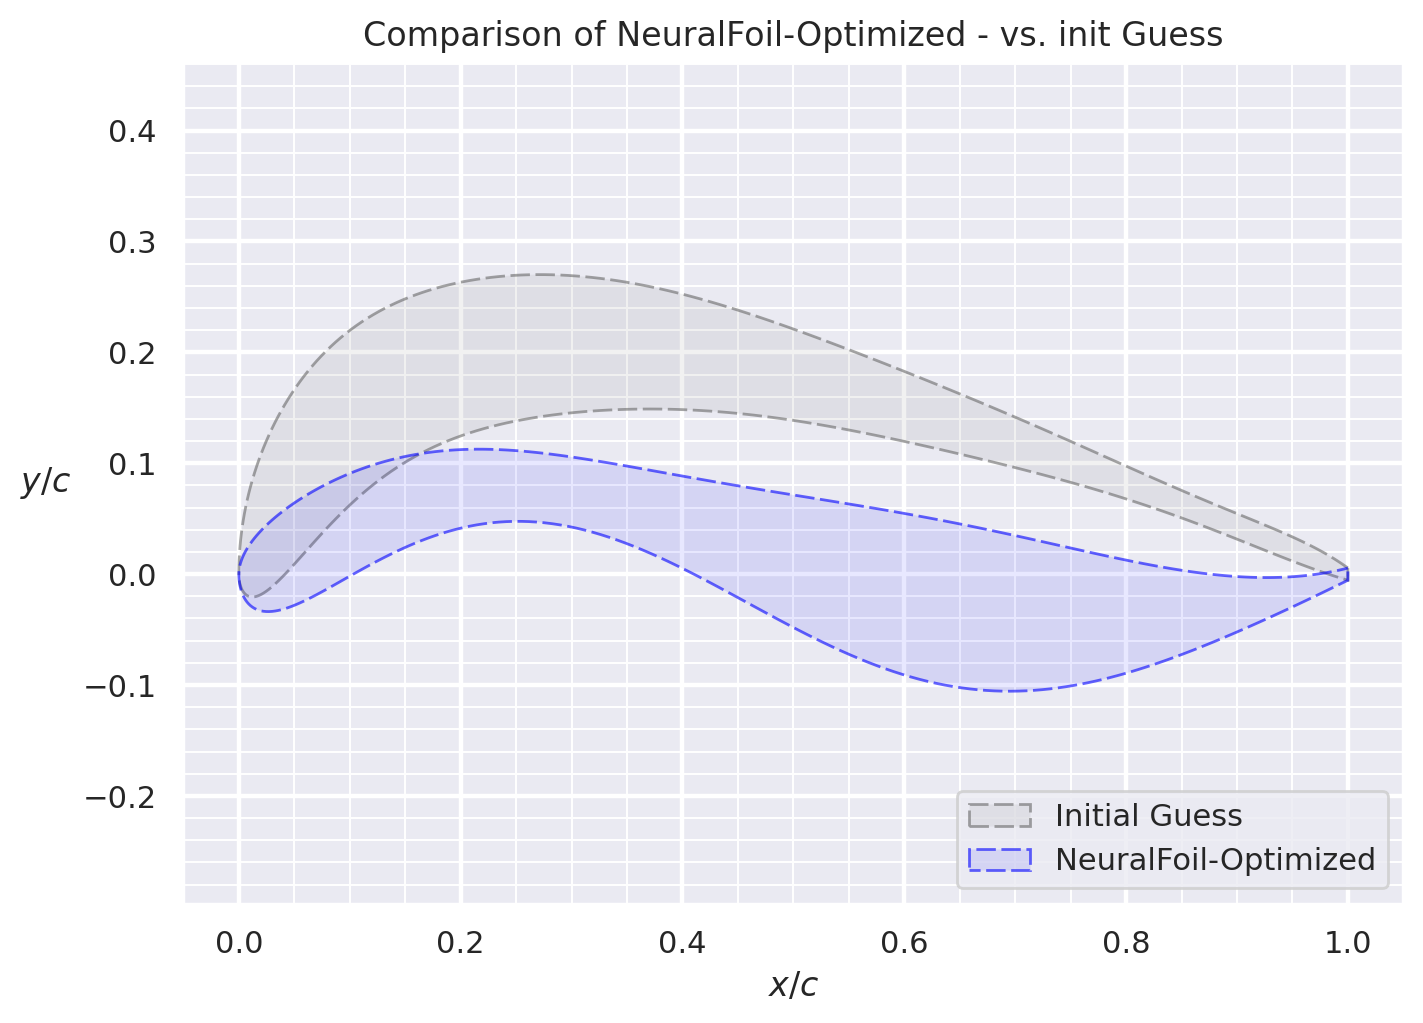

In [66]:
Re_plot = 500e3
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

airfoils_and_colors = {
    "Initial Guess"           : (initial_guess_airfoil, "dimgray"),
    "NeuralFoil-Optimized"    : (optimized_airfoil, "blue")}

for i, (name, (af, color)) in enumerate(airfoils_and_colors.items()):
    color = p.adjust_lightness(color, 1)
    ax.fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name,
        linestyle=(3 * i, (7, 2)),
        zorder=4 if "NeuralFoil" in name else 3,
    )

ax.legend(fontsize=11, loc="lower right", ncol=len(airfoils_and_colors)//2)
ax.set_title("Airfoil Shapes")
ax.set_xlabel("$x/c$")
ax.set_ylabel("$y/c$")
ax.axis('equal')

p.show_plot("Comparison of NeuralFoil-Optimized - vs. init Guess", legend=False)